In [2]:
import os
import shap
import numpy as np
import matplotlib.pyplot as plt

# Create folder to save SHAP plots if it doesn’t exist
save_dir = "../models/shap_outputs/"
os.makedirs(save_dir, exist_ok=True)

print("SHAP output directory ready:", save_dir)


SHAP output directory ready: ../models/shap_outputs/


In [5]:
import joblib

# Load your trained model
lgb_model = joblib.load("../models/best_model_lightgbm.pkl")  
print(" LightGBM model loaded")


 LightGBM model loaded


In [7]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import shap

#  Load processed features and target
X = pd.read_pickle("../data/processed/X_final.pkl")
y = pd.read_pickle("../data/processed/y.pkl")

print(" Features and target loaded")

#  Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(" Train/Test split done")

#  Train LightGBM model
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)
print(" Model trained")

#  Make predictions
y_pred = lgb_model.predict(X_test)
print(" Predictions ready")

#  Create SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)
print(" SHAP explainer created and SHAP values computed")


 Features and target loaded
 Train/Test split done
[LightGBM] [Info] Number of positive: 11321, number of negative: 109568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1132
[LightGBM] [Info] Number of data points in the train set: 120889, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093648 -> initscore=-2.269886
[LightGBM] [Info] Start training from score -2.269886
 Model trained
 Predictions ready
 SHAP explainer created and SHAP values computed


c:\Users\THINKPAD\Desktop\10_Academy\Week_5\fraud-detection\venv\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [12]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import os

# Folder to save plots
save_dir = "../models/shap_outputs/"
os.makedirs(save_dir, exist_ok=True)

# TreeExplainer (disable additivity check)
explainer = shap.TreeExplainer(lgb_model, data=X_test, model_output="probability")
shap_values_full = explainer.shap_values(X_test, check_additivity=False)

# Force into matrix
if isinstance(shap_values_full, list):
    # Binary classifier: take the second array for fraud class
    shap_matrix = np.array(shap_values_full[1])
else:
    shap_matrix = np.array(shap_values_full)

# Make sure it’s 2D: [n_samples, n_features]
if shap_matrix.ndim == 1:
    shap_matrix = shap_matrix.reshape(-1, X_test.shape[1])

# SHAP summary plot
plt.figure()
shap.summary_plot(shap_matrix, X_test, show=False)
plt.tight_layout()
plt.savefig(save_dir + "shap_summary_plot.png")
plt.close()

print(" SHAP summary plot saved:", save_dir + "shap_summary_plot.png")


 97%|=================== | 29397/30223 [00:36<00:01]       

 SHAP summary plot saved: ../models/shap_outputs/shap_summary_plot.png


In [17]:
import shap
import matplotlib.pyplot as plt
import os
import numpy as np

save_dir = "../models/shap_outputs/"
os.makedirs(save_dir, exist_ok=True)

# Force plots need shap_values as a 2D matrix: [n_samples, n_features]
# Ensure shap_values_full is an array
if isinstance(shap_values_full, list):
    # take first element for binary classifier (works with current shap version)
    shap_matrix = np.array(shap_values_full[1])
else:
    shap_matrix = np.array(shap_values_full)

# Make sure it's 2D: [n_samples, n_features]
if shap_matrix.ndim == 1:
    shap_matrix = shap_matrix.reshape(1, -1)

# Identify examples safely
def get_first_index(condition):
    indices = np.where(condition)[0]
    return indices[0] if len(indices) > 0 else None

tp_idx = get_first_index((y_test == 1) & (y_pred == 1))
fp_idx = get_first_index((y_test == 0) & (y_pred == 1))
fn_idx = get_first_index((y_test == 1) & (y_pred == 0))

cases = {"True_Positive": tp_idx, "False_Positive": fp_idx, "False_Negative": fn_idx}

for label, idx in cases.items():
    if idx is not None:
        plt.figure()
        shap.force_plot(
            explainer.expected_value,      # scalar
            shap_matrix[idx],              # 1D array for that sample
            X_test.iloc[idx],
            matplotlib=True,
            show=False
        )
        plt.savefig(save_dir + f"{label}_force_plot.png")
        plt.close()
        print(f"📌 Saved: {label}_force_plot.png")
    else:
        print(f"⚠️ No {label} example found in the test set")


📌 Saved: True_Positive_force_plot.png
⚠️ No False_Positive example found in the test set
📌 Saved: False_Negative_force_plot.png


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Displaying: shap_summary_plot.png


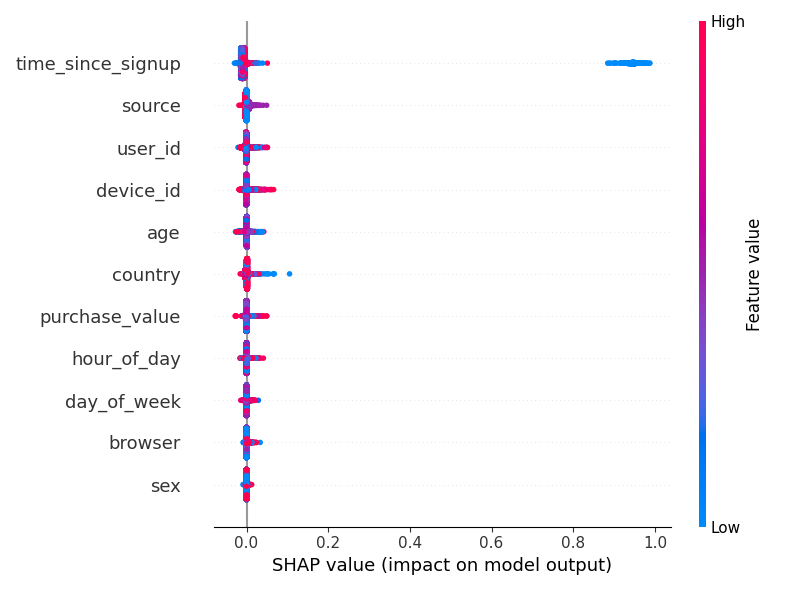

Displaying: True_Positive_force_plot.png


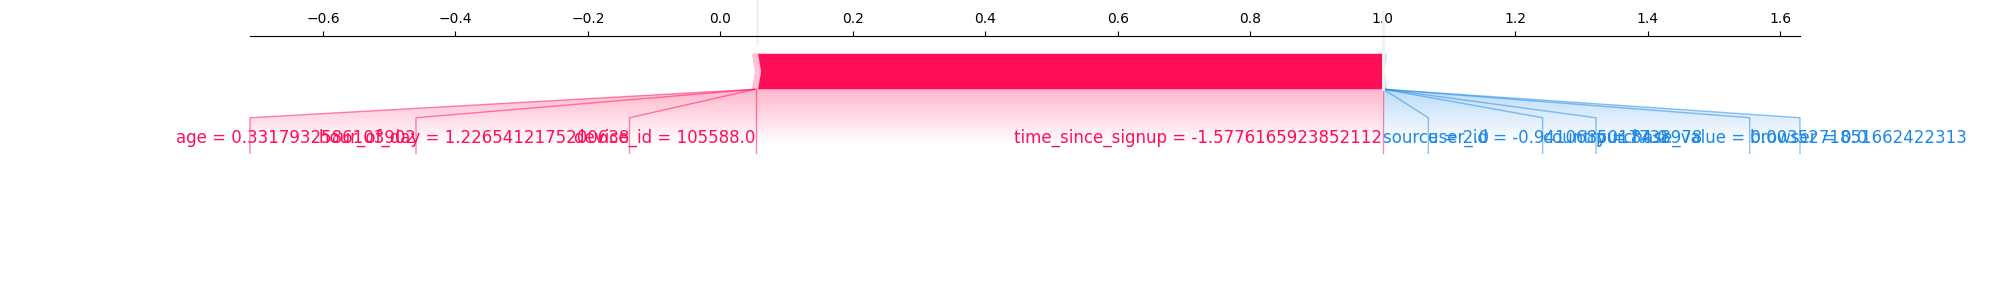

Displaying: False_Negative_force_plot.png


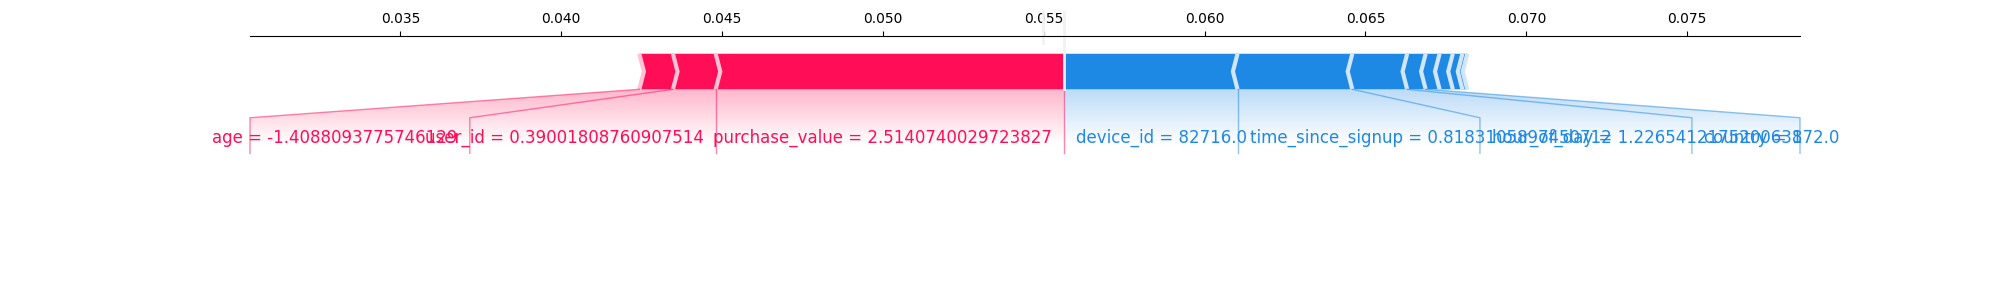

In [18]:
from IPython.display import Image, display
import os

# Folder where SHAP plots are saved
save_dir = "../models/shap_outputs/"

# List of plot files
plot_files = [
    "shap_summary_plot.png",
    "True_Positive_force_plot.png",
    "False_Negative_force_plot.png"  # FP doesn’t exist in your test set
]

# Display images in notebook
for file in plot_files:
    file_path = os.path.join(save_dir, file)
    if os.path.exists(file_path):
        print(f"Displaying: {file}")
        display(Image(filename=file_path))
    else:
        print(f"⚠️ File not found: {file}")
